<a href="https://colab.research.google.com/github/LugenderGeist/computer_vision_1/blob/main/comp_vision_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №1

Целью лаборатной работы является написание базовых функций, необходимых для обработки изображений. Необходимо реализовать следующие функции:
- Эрозия
- Дилатация
- Медианный фильтр
- Фильтр Гаусса
- Бинаризация
- Корректировка освещения

In [1]:
# импортируем библиотеки
import numpy as np
import cv2
#from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# подключаем гугл диск
#from google.colab import drive
#drive.mount('/content/drive')

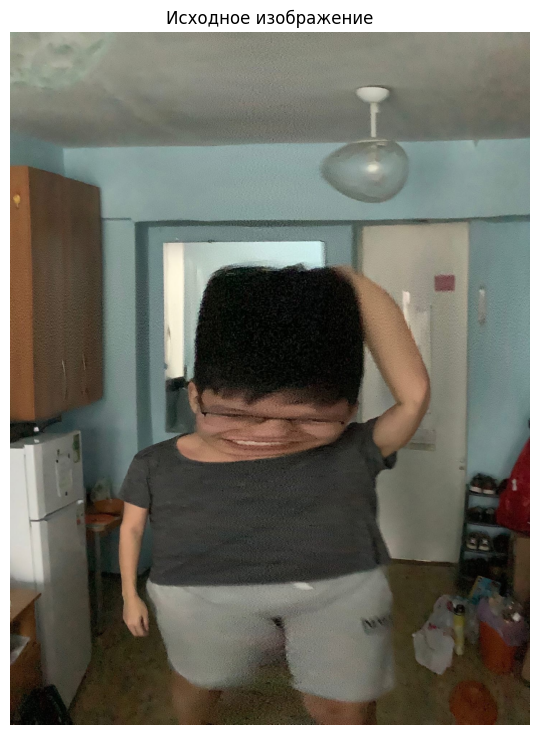

In [6]:
img = cv2.imread('2.jpg', 1)

# Инвертируем BGR в RGB
img = img[:, :, ::-1]

# Выводим изображение
plt.figure(figsize=(7, 9))
plt.title("Исходное изображение")
plt.imshow(img)
plt.axis('off')
plt.show()

## Паддинг

In [7]:
def pad(image, kernel):

    rows, cols = image.shape[:2]  # Размеры изображения
    k_rows, k_cols = kernel.shape  # Размеры ядра

    pad_rows = k_rows // 2
    pad_cols = k_cols // 2

    # Создаем новое изображение с увеличенными размерами
    padded_image_shape = list(image.shape)
    padded_image_shape[0] += 2 * pad_rows
    padded_image_shape[1] += 2 * pad_cols
    padded_image = np.zeros(padded_image_shape, dtype=image.dtype)

    # Копируем исходное изображение в центр нового изображения
    padded_image[pad_rows:pad_rows + rows, pad_cols:pad_cols + cols] = image

    # Заполняем паддинг зеркально
    for i in range(rows + 2 * pad_rows):
        for j in range(cols + 2 * pad_cols):
            # Вычисляем координаты относительно исходного изображения
            row = min(max(i - pad_rows, 0), rows - 1)
            col = min(max(j - pad_cols, 0), cols - 1)

            # Если мы находимся вне исходного изображения, используем зеркальное отражение
            if i < pad_rows:
                row = pad_rows - i - 1
            elif i >= rows + pad_rows:
                row = 2 * rows - i + pad_rows - 1

            if j < pad_cols:
                col = pad_cols - j - 1
            elif j >= cols + pad_cols:
                col = 2 * cols - j + pad_cols - 1

            padded_image[i, j] = image[row, col]

    return padded_image

## Эрозия

Эрозия - операция морфологической обработки изображений, которая используется для уменьшения или "сужения" объектов на изображении.
   
Так как суть функции в "затемнении", то в процессе прохода ядра по изображению центральный пиксель сравнивается с окружающими и в случае нахождения более темного - центральный пиксель заменяется на него.

Для обработки цветного изображения необходимо применить эрозию к каждому каналу по отдельности. Для этого

In [8]:
def erosion_grayscale(image, kernel):

    rows, cols = image.shape
    k_rows, k_cols = kernel.shape

    padded_image = pad(image, kernel)

    # Создаем выходное изображение того же размера, что и входное
    output_image = np.zeros_like(image, dtype=np.uint8)

    # Применяем ядро к каждому пикселю
    for i in range(rows):
        for j in range(cols):
            # Извлекаем окно из изображения, соответствующее размеру ядра
            window = padded_image[i:i + k_rows, j:j + k_cols]

            # Находим минимальное значение в окне, где ядро равно 1
            kernel_mask = kernel == 1
            if np.any(kernel_mask):  # Проверяем, есть ли активные элементы в ядре
                output_image[i, j] = np.min(window[kernel_mask])
            else:
                output_image[i, j] = image[i, j]  # Если ядро пустое, оставляем значение как есть

    return output_image

def erosion_color(image, kernel):

    # Разделяем изображение на каналы RGB
    red_channel = image[:, :, 0]
    green_channel = image[:, :, 1]
    blue_channel = image[:, :, 2]

    # Применяем эрозию к каждому каналу независимо
    eroded_red = erosion_grayscale(red_channel, kernel)
    eroded_green = erosion_grayscale(green_channel, kernel)
    eroded_blue = erosion_grayscale(blue_channel, kernel)

    # Объединяем обработанные каналы обратно в одно изображение
    eroded_image = np.dstack([eroded_red, eroded_green, eroded_blue])

    return eroded_image

In [9]:
# Загрузка цветного изображения
img_array = np.array(img)

# Определим ядро
kernel = np.array([[0, 1, 0],
                   [1, 1, 1],
                   [0, 1, 0]], dtype=np.uint8)

# Применение эрозии
eroded_img_array = erosion_color(img_array, kernel)

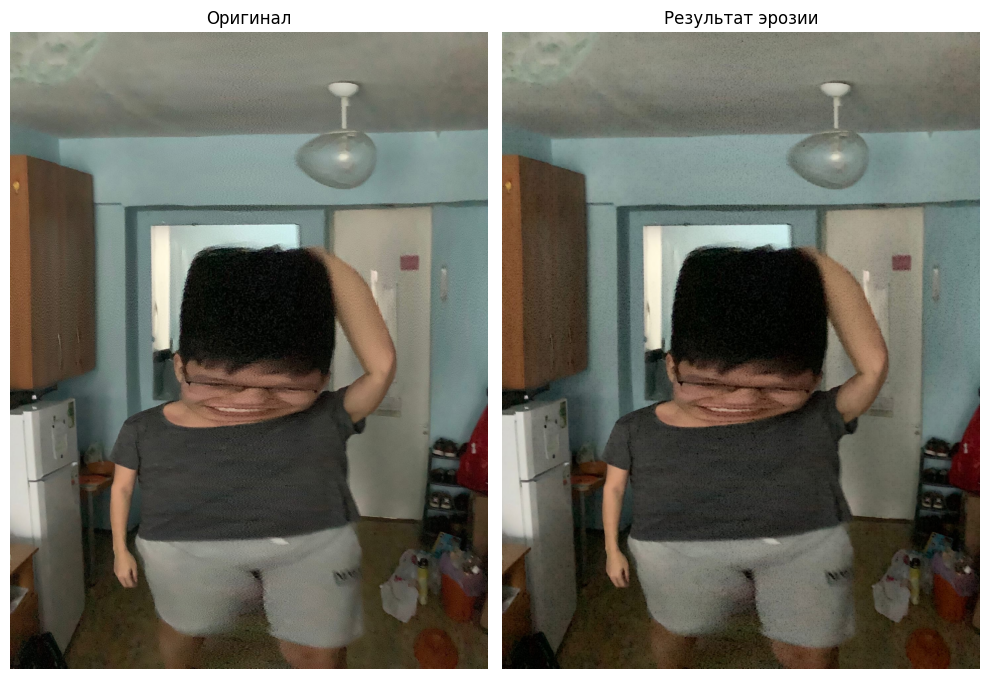

In [10]:
# Вывод результатов
plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 1)
plt.title("Оригинал")
plt.imshow(img_array)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Результат эрозии")
plt.imshow(eroded_img_array)
plt.axis('off')

plt.tight_layout()
plt.show()

## Дилатация

Дилатация - операция морфологической обработки изображений, которая используется для увеличения или "расширения" объектов на изображении.  
  
Логика дилатации: если хотя бы один пиксель под структурным элементом совпадает с пикселем объекта (имеет значение 1), то центральный пиксель становится 1. Иначе он остаётся 0.

In [11]:
def dilation_grayscale(image, kernel):

    rows, cols = image.shape
    k_rows, k_cols = kernel.shape

    padded_image = pad(image, kernel)

    # Создаем выходное изображение того же размера, что и входное
    output_image = np.zeros_like(image, dtype=np.uint8)

    # Применяем ядро к каждому пикселю
    for i in range(rows):
        for j in range(cols):
            # Извлекаем окно из изображения, соответствующее размеру ядра
            window = padded_image[i:i + k_rows, j:j + k_cols]

            # Находим максимальное значение в окне, где ядро равно 1
            kernel_mask = kernel == 1
            if np.any(kernel_mask):  # Проверяем, есть ли активные элементы в ядре
                output_image[i, j] = np.max(window[kernel_mask])
            else:
                output_image[i, j] = image[i, j]  # Если ядро пустое, оставляем значение как есть

    return output_image

def dilation_color(image, kernel):

    red_channel = image[:, :, 0]
    green_channel = image[:, :, 1]
    blue_channel = image[:, :, 2]

    dilation_red = dilation_grayscale(red_channel, kernel)
    dilation_green = dilation_grayscale(green_channel, kernel)
    dilation_blue = dilation_grayscale(blue_channel, kernel)

    dilation_image = np.dstack([dilation_red, dilation_green, dilation_blue])

    return dilation_image

In [12]:
# Загрузка цветного изображения
img_array = np.array(img)

# Определим ядро
kernel = np.array([[0, 1, 0],
                   [1, 1, 1],
                   [0, 1, 0]], dtype=np.uint8)

# Применение дилатации
dilated_img_array = dilation_color(img_array, kernel)

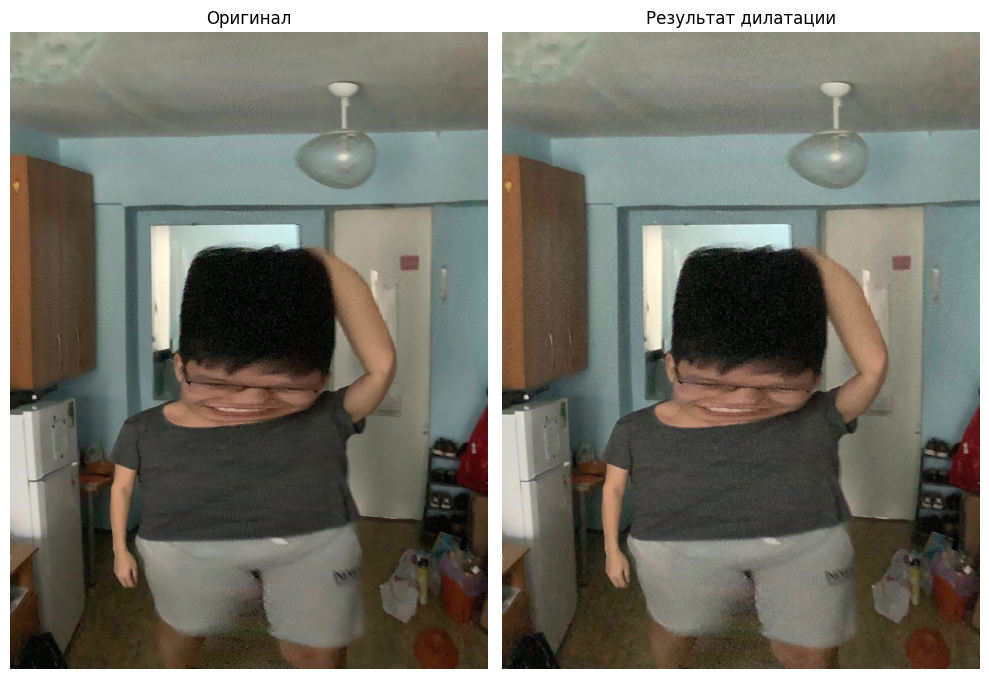

In [13]:
plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 1)
plt.title("Оригинал")
plt.imshow(img_array)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Результат дилатации")
plt.imshow(dilated_img_array)
plt.axis('off')

plt.tight_layout()
plt.show()

## Медианный фильтр

Медианный фильтр - это метод обработки изображений, который используется для устранения шума при сохранении чётких границ объектов. В отличие от других фильтров (например, гауссового), медианный фильтр не размывает изображение, а заменяет значение каждого пикселя на медиану значений в его окрестности.
   
Принцип работы:
1. Выбирается окно определённого размера, которое перемещается по всему изображению.
2. Для каждого положения окна все пиксели внутри него сортируются по яркости.
3. Центральный пиксель окна заменяется на медианное значение из отсортированного списка.

In [14]:
def median_filter_grayscale(image, kernel):

    rows, cols = image.shape
    k_rows, k_cols = kernel.shape

    padded_image = pad(image, kernel)

    # Создаем выходное изображение того же размера, что и входное
    output_image = np.zeros_like(image, dtype=np.uint8)

    # Применяем медианный фильтр
    for i in range(rows):
        for j in range(cols):
            # Извлекаем окно из изображения, соответствующее размеру ядра
            window = padded_image[i:i + k_rows, j:j + k_cols]

            # Применяем маску ядра: оставляем только те значения, где ядро == 1
            kernel_mask = kernel == 1
            if np.any(kernel_mask):  # Проверяем, есть ли активные элементы в ядре
                filtered_window = window[kernel_mask]
                output_image[i, j] = np.median(filtered_window)
            else:
                output_image[i, j] = image[i, j]  # Если ядро пустое, оставляем значение как есть

    return output_image

def median_filter_color(image, kernel):

    red_channel = image[:, :, 0]
    green_channel = image[:, :, 1]
    blue_channel = image[:, :, 2]

    m_filter_red = median_filter_grayscale(red_channel, kernel)
    m_filter_green = median_filter_grayscale(green_channel, kernel)
    m_filter_blue = median_filter_grayscale(blue_channel, kernel)

    m_filtered_image = np.dstack([m_filter_red, m_filter_green, m_filter_blue])

    return m_filtered_image

In [15]:
img_array = np.array(img)

kernel = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]], dtype=np.uint8)

filtered_img_array = median_filter_color(img_array, kernel)

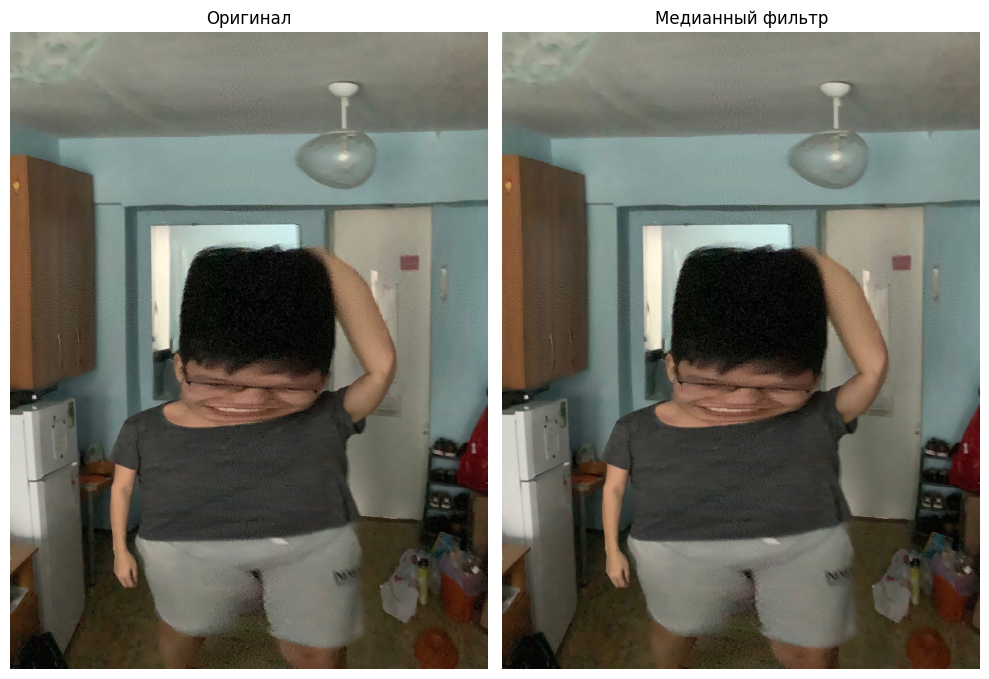

In [16]:
plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 1)
plt.title("Оригинал")
plt.imshow(img_array)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Медианный фильтр")
plt.imshow(filtered_img_array)
plt.axis('off')

plt.tight_layout()
plt.show()

## Фильтр Гаусса

Фильтр Гаусса - метод обработки изображений, направленный на сглаживание изображения путем уменьшения высокочастотных компонентов, при этом сохраняется общая структура изображения.

In [17]:
def generate_gauss_kernel(size, sigma=1.0):

    # Создаем сетку координат
    ax = np.arange(-size // 2 + 1, size // 2 + 1)
    xx, yy = np.meshgrid(ax, ax)

    # Вычисляем ядро Гаусса
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel /= np.sum(kernel)  # Нормализация ядра

    return kernel

def gauss_filter_grayscale(image, kernel):

    rows, cols = image.shape
    k_rows, k_cols = kernel.shape

    padded_image = pad(image, kernel)

    # Создаем выходное изображение того же размера, что и входное
    output_image = np.zeros_like(image, dtype=np.float32)

    # Применяем фильтр Гаусса
    for i in range(rows):
        for j in range(cols):
            # Извлекаем окно из изображения, соответствующее размеру ядра
            window = padded_image[i:i + k_rows, j:j + k_cols]

            # Выполняем свертку (поэлементное умножение и суммирование)
            output_image[i, j] = np.sum(window * kernel)

    # Преобразуем результат обратно в uint8
    output_image = np.clip(output_image, 0, 255).astype(np.uint8)

    return output_image

def gauss_filter_color(image, kernel):

    red_channel = image[:, :, 0]
    green_channel = image[:, :, 1]
    blue_channel = image[:, :, 2]

    g_filter_red = gauss_filter_grayscale(red_channel, kernel)
    g_filter_green = gauss_filter_grayscale(green_channel, kernel)
    g_filter_blue = gauss_filter_grayscale(blue_channel, kernel)

    g_filtered_image = np.dstack([g_filter_red, g_filter_green, g_filter_blue])

    return g_filtered_image

In [18]:
img_array = np.array(img)

# Генерация ядра Гаусса
kernel_size = 5
sigma = 1.0
kernel = generate_gauss_kernel(kernel_size, sigma)

filtered_img_array = gauss_filter_color(img_array, kernel)

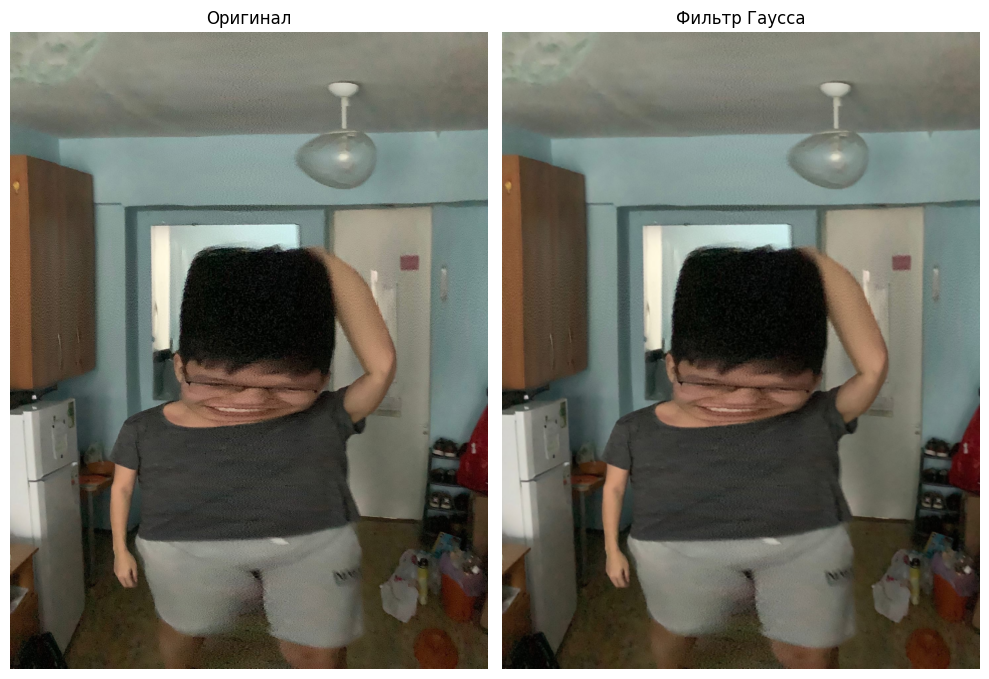

In [19]:
plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 1)
plt.title("Оригинал")
plt.imshow(img_array)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Фильтр Гаусса")
plt.imshow(filtered_img_array)
plt.axis('off')

plt.tight_layout()
plt.show()

## Бинаризация

Бинаризация — это процесс преобразования изображения с множеством уровней яркости в изображение с двумя уровнями яркости: черный и белый (0 и 255).
Для того, чтобы применить функцию бинаризации - переведем изображение в grayscale.

 Это необходимо, так как каждый из каналов RGB находится в пределах от 0 до 255, соответственно, при применении бинаризации к цветному изображению будут получены максимальные и минимальные значения для каждого из каналов RGB.

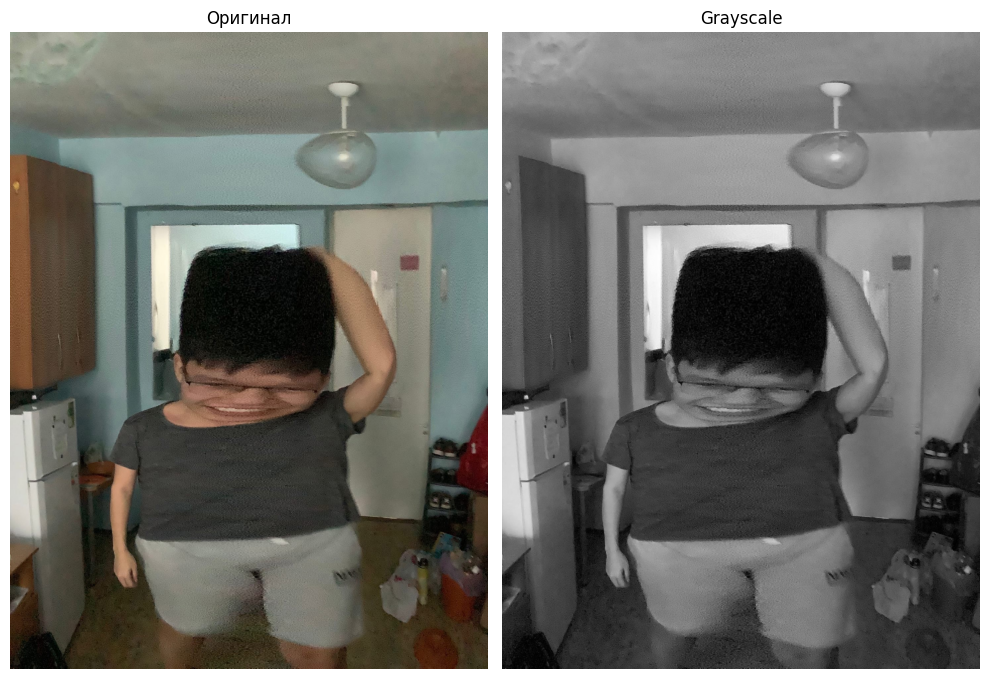

In [20]:
# Разбиваем изображение на каналы
red_channel = img[:, :, 0].astype(np.float32)
green_channel = img[:, :, 1].astype(np.float32)
blue_channel = img[:, :, 2].astype(np.float32)

# Применяем формулу для преобразования в grayscale
grayscale_image = 0.299 * red_channel + 0.587 * green_channel + 0.114 * blue_channel

# Преобразуем результат обратно в uint8
grayscale_image = np.clip(grayscale_image, 0, 255).astype(np.uint8)

plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 1)
plt.title("Оригинал")
plt.imshow(img_array)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Grayscale")
plt.imshow(grayscale_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [21]:
# Функция бинаризации
def binarize_image(image, threshold):

    binary_image = (image > threshold).astype(np.uint8) * 255

    return binary_image

In [22]:
img_array = np.array(grayscale_image)

# threshold - порог бинаризации
threshold = 105
binary_img_array = binarize_image(img_array, threshold)

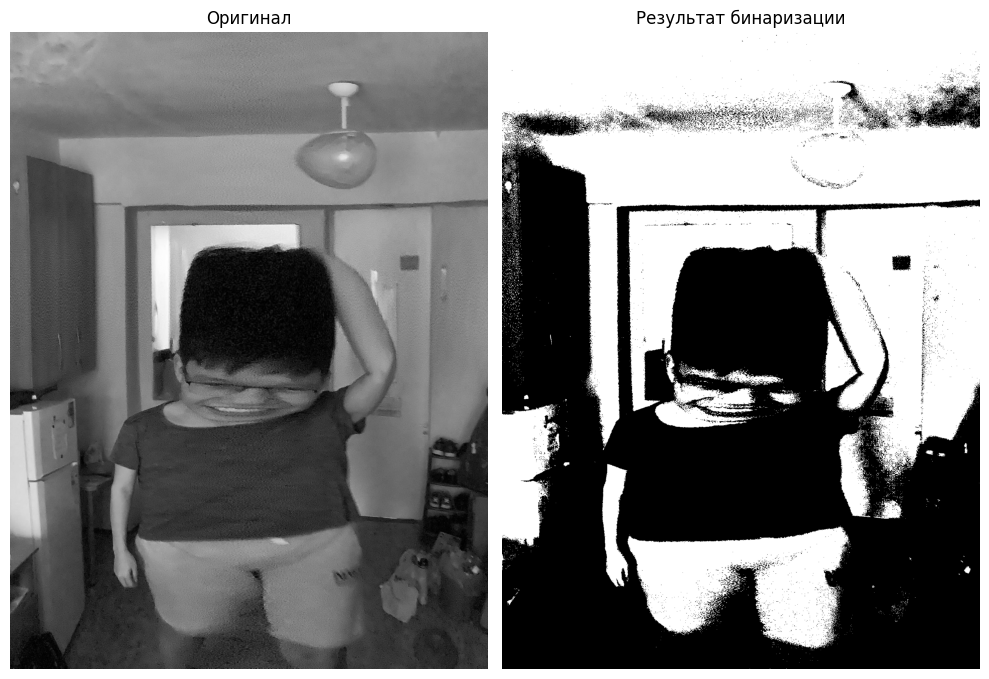

In [23]:
plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 1)
plt.title("Оригинал")
plt.imshow(img_array, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Результат бинаризации")
plt.imshow(binary_img_array, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

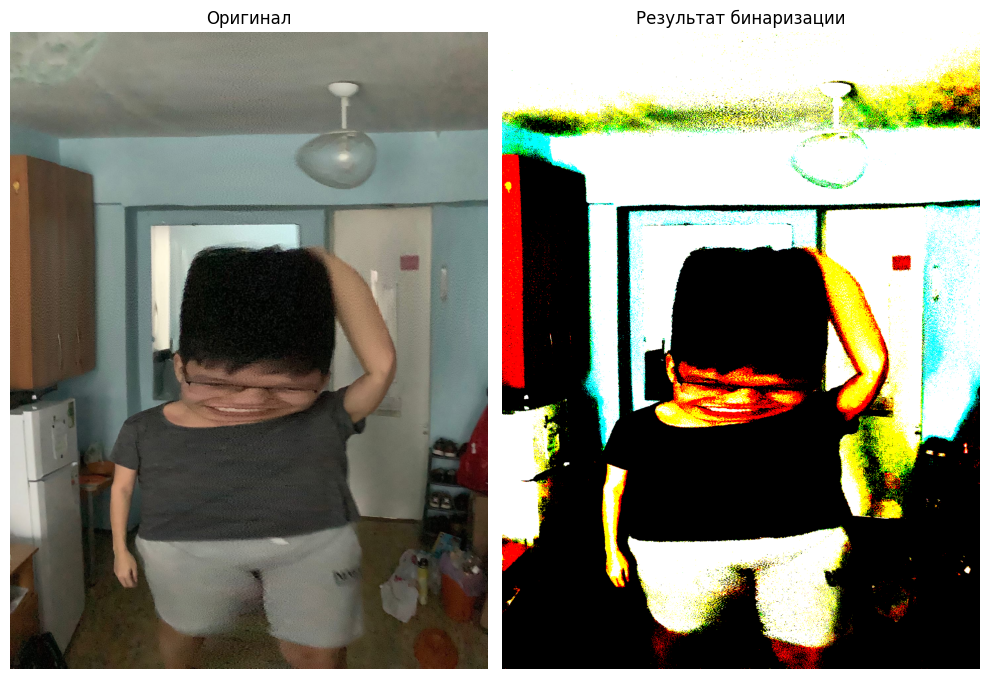

In [24]:
img_array = np.array(img)

# threshold - порог бинаризации
threshold = 105
binary_img_array = binarize_image(img_array, threshold)

plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 1)
plt.title("Оригинал")
plt.imshow(img_array, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Результат бинаризации")
plt.imshow(binary_img_array, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

## Корректировка освещения

Корректировка освещения — это процесс улучшения качества изображения путем нормализации или выравнивания интенсивности света по всему кадру.

Для корректировки освещения на изображении с использованием гистограммы можно применить глобальное выравнивание гистограммы . Этот метод увеличивает контрастность изображения, распределяя интенсивности пикселей более равномерно по всему диапазону яркости (от 0 до 255).

In [25]:
def calculate_histogram(image):

    hist = np.zeros(256, dtype=np.int32)
    for value in image.flat:
        hist[value] += 1

    return hist

def equalize_histogram(image):

    # Вычисляем гистограмму
    hist = calculate_histogram(image)
    # Вычисляем накопленную функцию распределения (CDF)
    cdf = hist.cumsum()
    # Нормализуем CDF для получения маппинга значений
    cdf_normalized = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())
    # Создаем таблицу преобразования
    mapping_table = cdf_normalized.astype(np.uint8)
    # Применяем маппинг к каждому пикселю
    equalized_image = mapping_table[image]

    return equalized_image

def equalize_histogram_color(image):

    channels = [equalize_histogram(image[:, :, i]) for i in range(3)]

    return np.dstack(channels)

In [26]:
# Обработка изображения
img_array = np.array(img)
corrected = equalize_histogram(img_array)

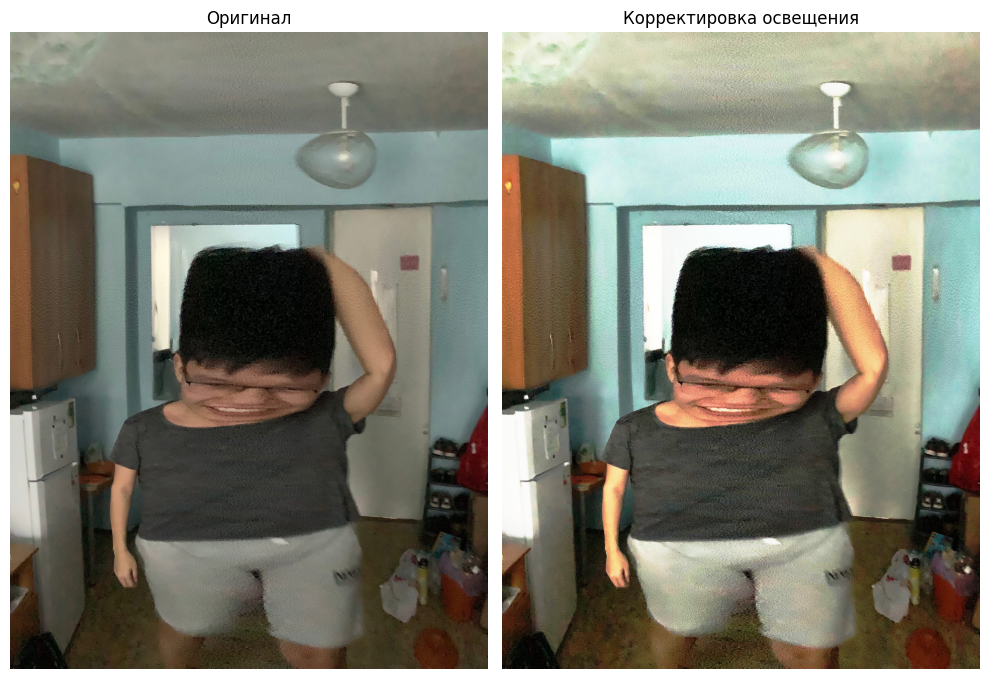

In [27]:
plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 1)
plt.title("Оригинал")
plt.imshow(img_array, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Корректировка освещения")
plt.imshow(corrected, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()